/tmp/ipykernel_638754/3531422451.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"] + filtered_df["GPU_Memory_Usage"].fillna(0)
/tmp/ipykernel_638754/3531422451.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Algorithm-Method"] = filtered_df["Algorithm"] + " - " + filtered_df["Method"]
/tmp/ipykernel_638754/3531422451.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

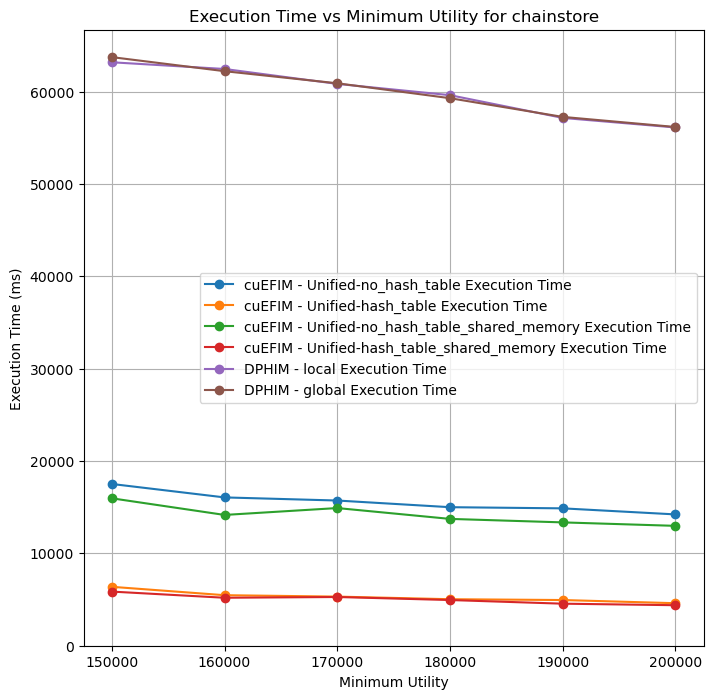

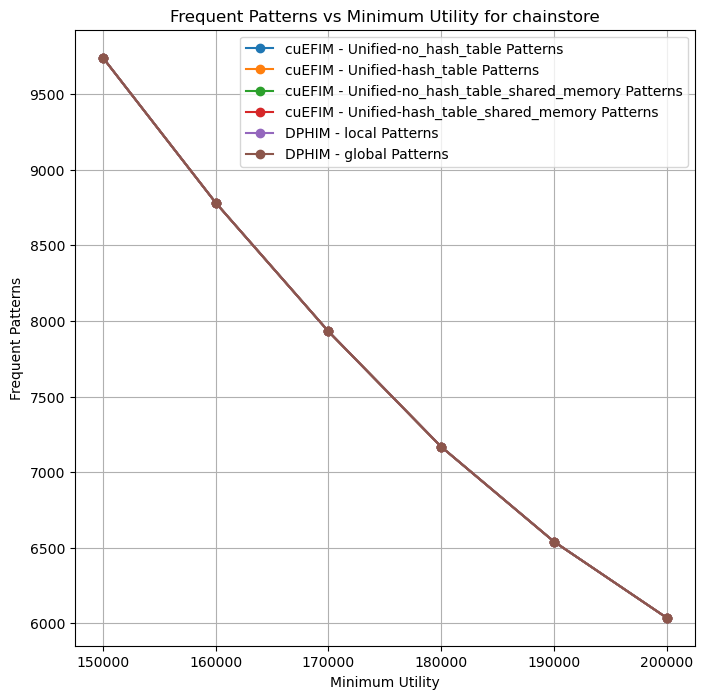

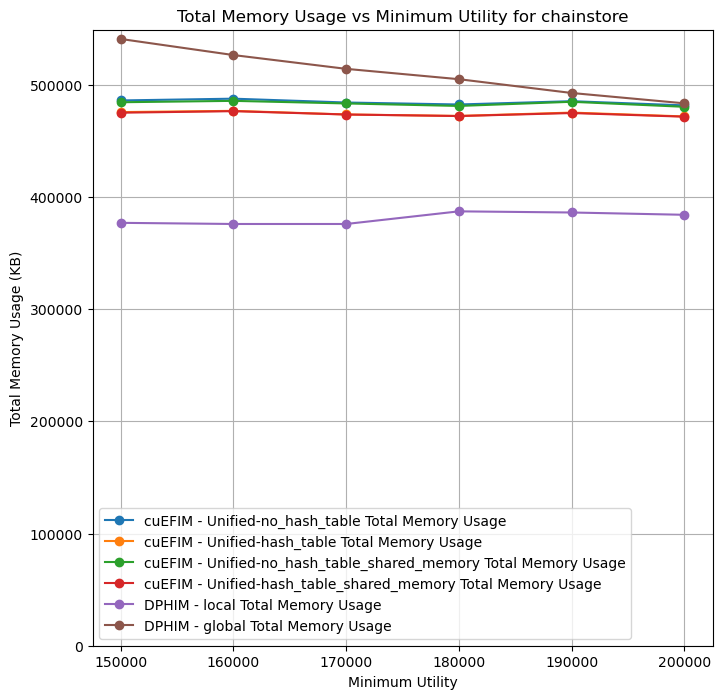

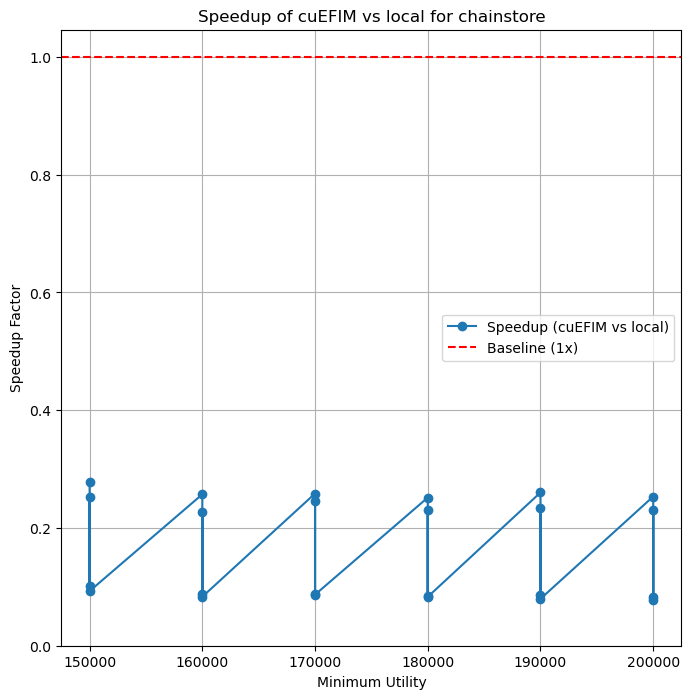

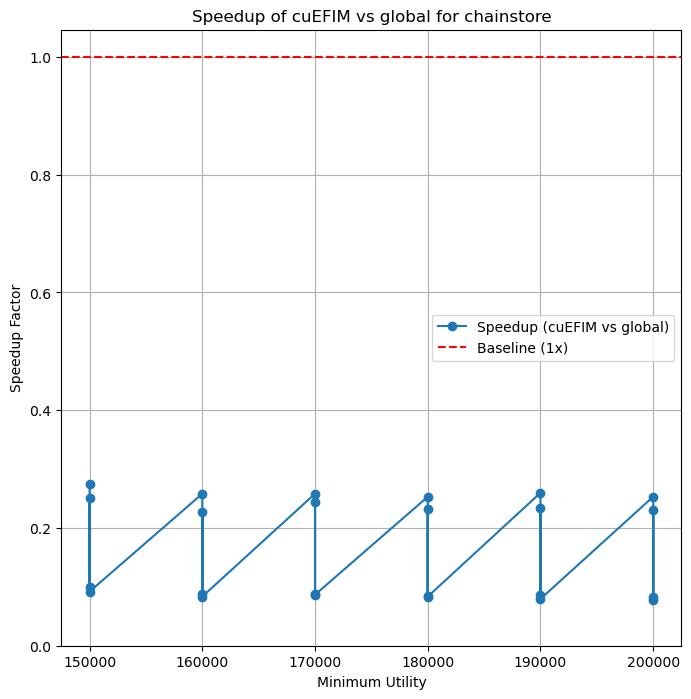

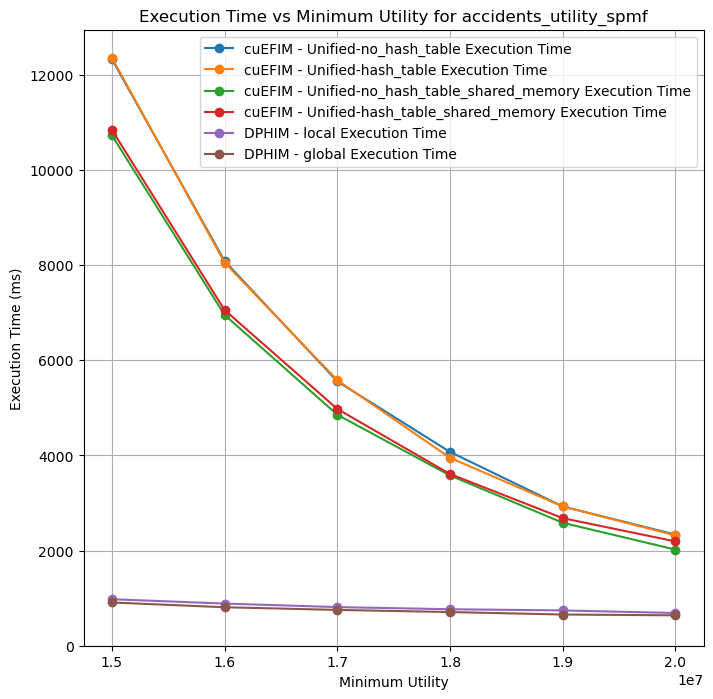

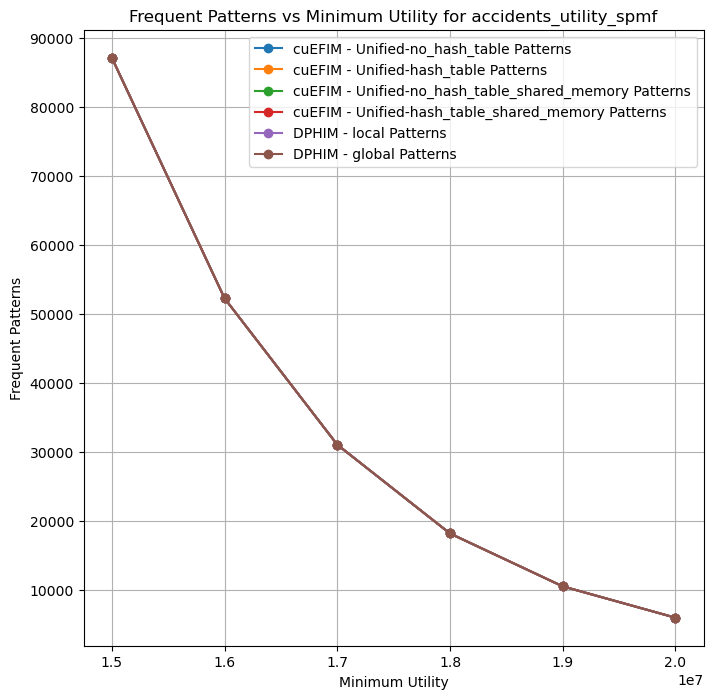

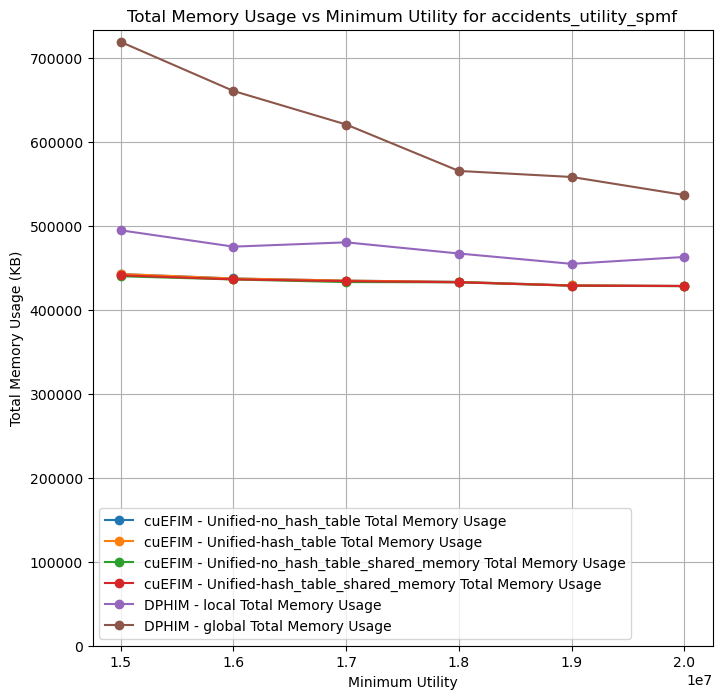

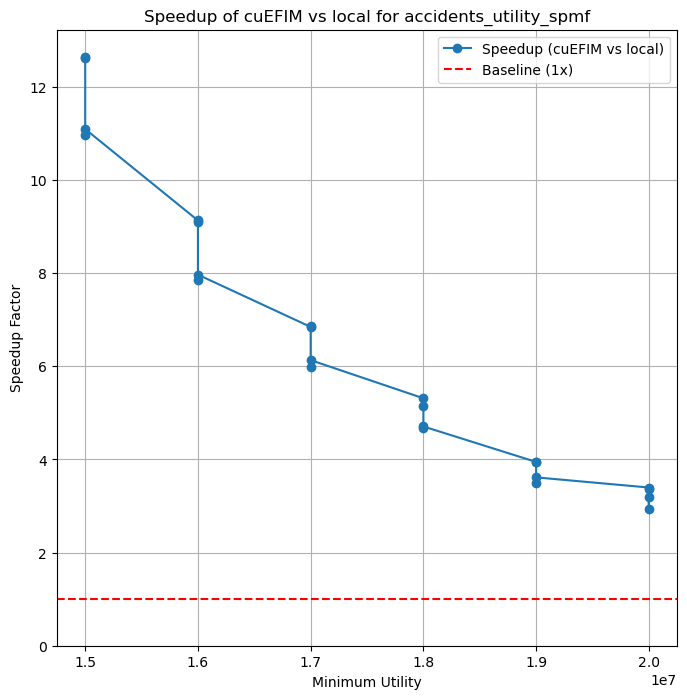

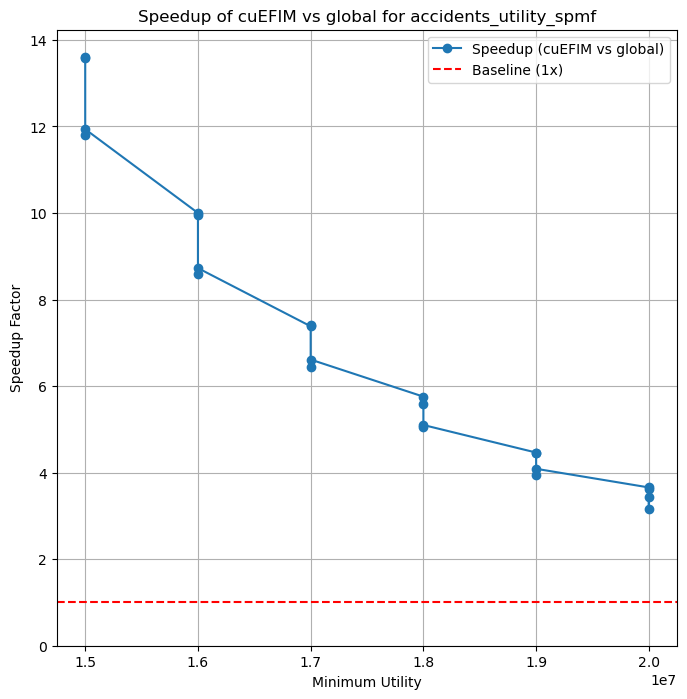

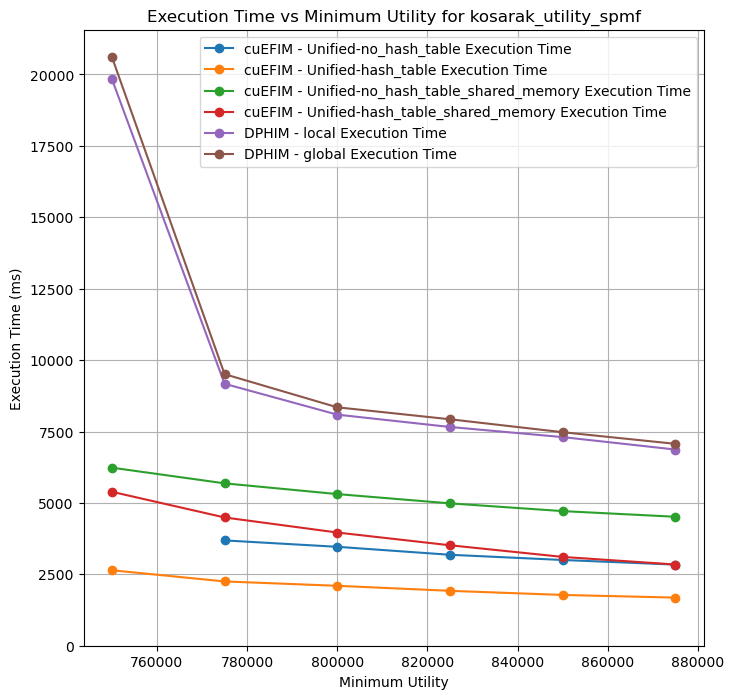

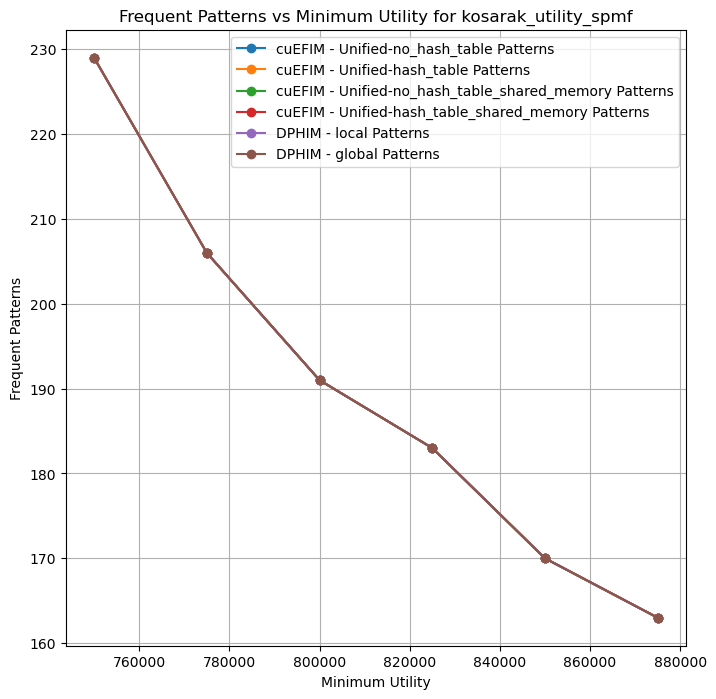

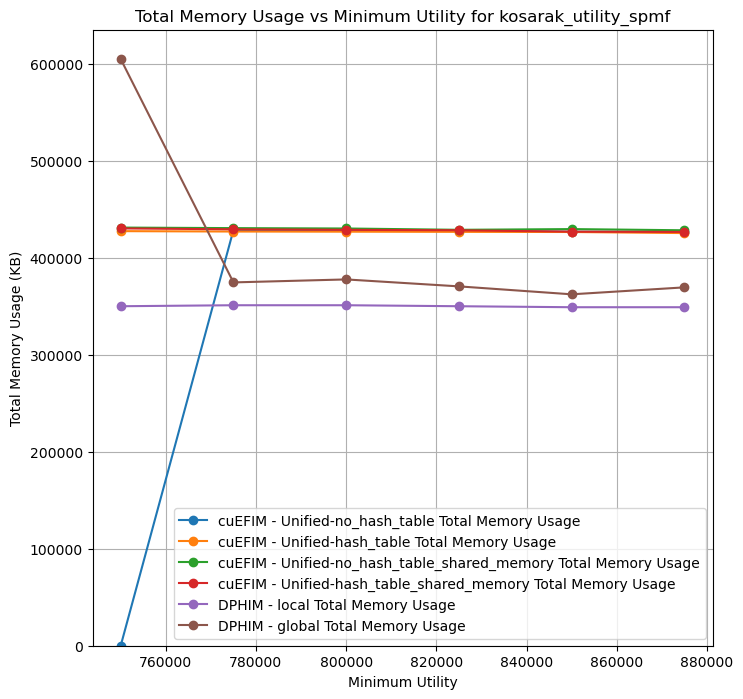

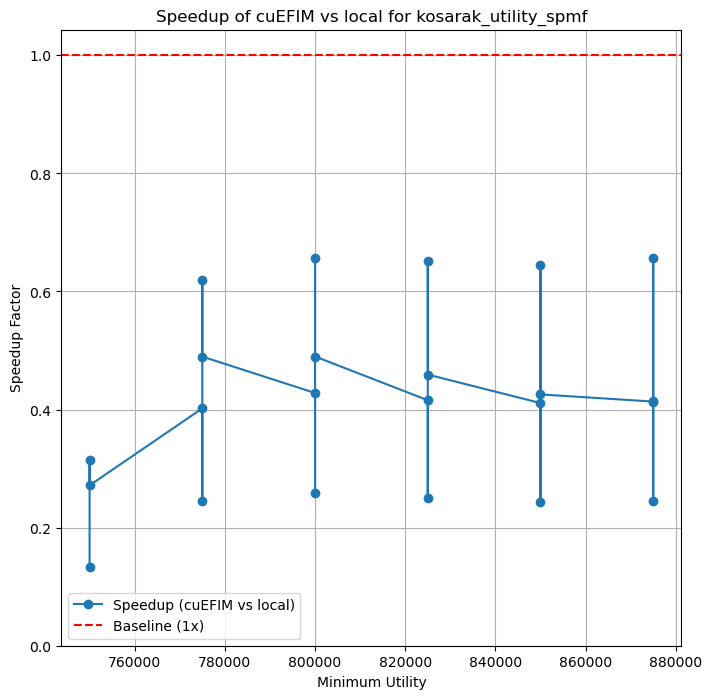

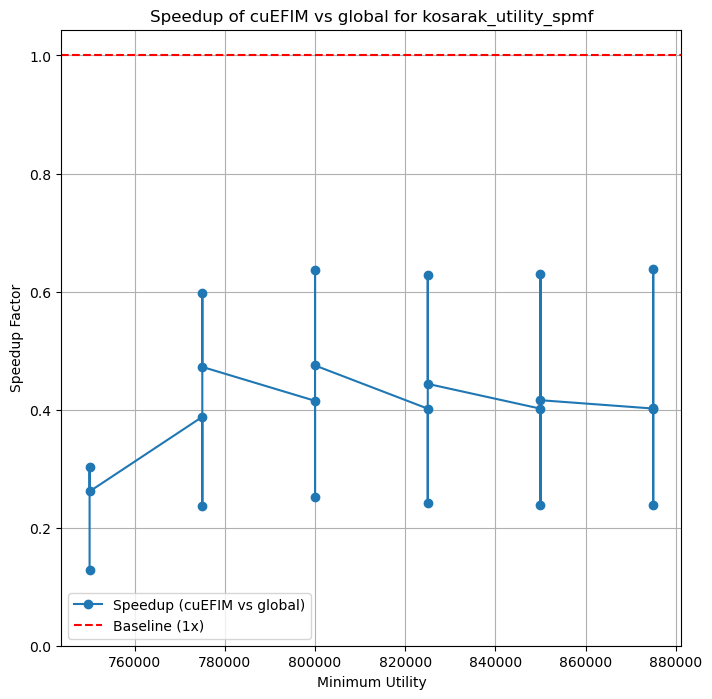

In [3]:
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt

# Initialize a consolidated DataFrame
columns = ["Algorithm", "Method", "File", "Minimum_Utility", "Execution_Time", "Frequent_Patterns", "GPU_Memory_Usage", "CPU_Memory_Usage"]
# results_df = pd.DataFrame(columns=columns)
if os.path.exists("combined_results.csv"):
    results_df = pd.read_csv("combined_results.csv")
else:
    results_df = pd.DataFrame(columns=columns)

def save_results():
    """Save results DataFrame to CSV."""
    results_df.to_csv("combined_results.csv", index=False)

def has_run_before(algorithm, method, file_name, min_util):
    """Check if an algorithm has already processed a file with a specific minimum utility."""
    return not results_df[
        (results_df["Algorithm"] == algorithm) &
        (results_df["Method"] == method) &
        (results_df["File"] == os.path.splitext(os.path.basename(file_name))[0]) &
        (results_df["Minimum_Utility"] == min_util)
    ].empty

def run_cuEFIM(process_data, memory_method):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            for method in memory_method:
                if has_run_before("EFIM", method, file_path, min_util):
                    print(f"Skipping EFIM for File: {file_path}, Min Util: {min_util} (Already Processed)")
                    continue
                
                mem_meth = method.split("-")
                command = [
                    "/home/tarun/cudaEFIM/build/cuEFIM",
                    "--input-file", file_path,
                    "--output-file", "output.txt",
                    "--seperator", r"\s",
                    "--min-utility", str(min_util),
                    "--memory", mem_meth[0],
                    "--method", mem_meth[1],
                ]
                try:
                    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                    output = result.stdout

                    execution_time = None
                    frequent_patterns = None
                    max_gpu_memory = 0.0
                    max_cpu_memory = 0
                    for line in output.splitlines():
                        if "End" in line:
                            line = line.split(" ")
                            line = [x for x in line if x]
                            execution_time = float(line[1])
                            execution_time = int(execution_time * 1000)  # Convert to ms
                        elif "Number of patterns:" in line:
                            frequent_patterns = int(line.split("Number of patterns:")[-1].strip())
                        elif "Iter" in line:
                            line = line.split(" ")
                            line = [x for x in line if x]
                            cpu_memory = float(line[2]) * 1024 # Convert to \
                            max_cpu_memory = max(max_cpu_memory, cpu_memory)

                            gpu_memory = float(line[3]) * 1024  # Convert to KB
                            max_gpu_memory = max(max_gpu_memory, gpu_memory)


                    print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}, GPU Memory: {max_gpu_memory}, CPU Memory: {max_cpu_memory}")
                    new_entry = {
                        "Algorithm": "cuEFIM",
                        "Method": method,
                        "File": os.path.splitext(os.path.basename(file_path))[0],
                        "Minimum_Utility": min_util,
                        "Execution_Time": execution_time,
                        "Frequent_Patterns": frequent_patterns,
                        "GPU_Memory_Usage": max_gpu_memory,
                        "CPU_Memory_Usage": max_cpu_memory
                    }
                    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                    save_results()
                except Exception as e:
                    print(f"Error running EFIM: {e}")


def run_dphim(process_data, method):
    global results_df
    for entry in process_data:
        file_path, min_utilities = entry
        for min_util in min_utilities:
            for meth in method:
                if has_run_before("DPHIM", meth, file_path, min_util):
                    print(f"Skipping DPHIM for File: {file_path}, Min Util: {min_util} (Already Processed)")
                    continue

                command = [
                    "/home/tarun/dphim/build/run",
                    "-i", file_path,
                    "-m", str(min_util),
                    "-s", meth,
                    "-t", "16",
                    "-o", "/dev/null"
                ]
                try:
                    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
                    output = result.stdout
                    execution_time = None
                    frequent_patterns = None
                    total_rss = 0  # Initialize total RSS to 0

                    for line in output.splitlines():
                        if "Total time ~:" in line:
                            execution_time = int(line.split("Total time ~:")[-1].strip().split(" ")[0])  # Convert to ms
                        elif "High utility itemsets count:" in line:
                            frequent_patterns = int(line.split("High utility itemsets count:")[-1].strip())

                    # take the last 5 lines of the output to get the memory usage
                    last_lines = output.splitlines()[-2:]
                    for line in last_lines:
                        splitted  = [x for x in line.split(" ") if x]
                        for item in splitted:
                            if "MB" == item:
                                total_rss += int(splitted[splitted.index(item) - 1]) * 1024
                    print(f"File: {file_path}, Min Util: {min_util}, Execution Time: {execution_time}, Patterns: {frequent_patterns}, CPU Memory: {total_rss} KB")
                    new_entry = {
                        "Algorithm": "DPHIM",
                        "Method": meth,
                        "File": os.path.splitext(os.path.basename(file_path))[0],
                        "Minimum_Utility": min_util,
                        "Execution_Time": execution_time,
                        "Frequent_Patterns": frequent_patterns,
                        "CPU_Memory_Usage": total_rss
                    }
                    results_df = pd.concat([results_df, pd.DataFrame([new_entry])], ignore_index=True)
                    save_results()
                except Exception as e:
                    print(f"Error running DPHIM: {e}")


import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(results_df, file_name):
    figure_size = (8, 8)

    # Filter DataFrame for the specified file
    filtered_df = results_df[results_df['File'] == os.path.splitext(file_name)[0]]

    # Combine CPU and GPU memory into a single column
    if "GPU_Memory_Usage" in filtered_df.columns:
        filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"] + filtered_df["GPU_Memory_Usage"].fillna(0)
    else:
        filtered_df["Total_Memory_Usage"] = filtered_df["CPU_Memory_Usage"]

    # Group by Algorithm and Method
    filtered_df["Algorithm-Method"] = filtered_df["Algorithm"] + " - " + filtered_df["Method"]

    # Plot Execution Time vs Minimum Utility
    plt.figure(figsize=figure_size)
    for alg_method in filtered_df["Algorithm-Method"].unique():
        subset = filtered_df[filtered_df["Algorithm-Method"] == alg_method]
        plt.plot(subset["Minimum_Utility"], subset["Execution_Time"], marker='o', label=f"{alg_method} Execution Time")
    plt.title(f"Execution Time vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Execution Time (ms)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_execution_time.svg")

    # Plot Frequent Patterns vs Minimum Utility
    plt.figure(figsize=figure_size)
    for alg_method in filtered_df["Algorithm-Method"].unique():
        subset = filtered_df[filtered_df["Algorithm-Method"] == alg_method]
        plt.plot(subset["Minimum_Utility"], subset["Frequent_Patterns"], marker='o', label=f"{alg_method} Patterns")
    plt.title(f"Frequent Patterns vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Frequent Patterns")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_patterns.svg")

    # Plot Total Memory Usage vs Minimum Utility
    plt.figure(figsize=figure_size)
    for alg_method in filtered_df["Algorithm-Method"].unique():
        subset = filtered_df[filtered_df["Algorithm-Method"] == alg_method]
        plt.plot(subset["Minimum_Utility"], subset["Total_Memory_Usage"], marker='o', label=f"{alg_method} Total Memory Usage")
    plt.title(f"Total Memory Usage vs Minimum Utility for {os.path.splitext(file_name)[0]}")
    plt.xlabel("Minimum Utility")
    plt.ylabel("Total Memory Usage (KB)")
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0)
    plt.savefig(f"{os.path.splitext(file_name)[0]}_total_memory.svg")

    # Calculate and Plot Speedup
    cuEFIM_df = filtered_df[filtered_df["Algorithm"] == "cuEFIM"]
    for method in filtered_df["Method"].unique():
        dphim_df = filtered_df[(filtered_df["Algorithm"] != "cuEFIM") & (filtered_df["Method"] == method)]
        if not cuEFIM_df.empty and not dphim_df.empty:
            speedup_df = pd.merge(cuEFIM_df, dphim_df, on="Minimum_Utility", suffixes=('_cuEFIM', '_Other'))
            speedup_df["Speedup"] = speedup_df["Execution_Time_cuEFIM"] / speedup_df["Execution_Time_Other"]

            plt.figure(figsize=figure_size)
            plt.plot(speedup_df["Minimum_Utility"], speedup_df["Speedup"], marker='o', label=f"Speedup (cuEFIM vs {method})")
            plt.axhline(y=1, color='r', linestyle='--', label="Baseline (1x)")
            plt.title(f"Speedup of cuEFIM vs {method} for {os.path.splitext(file_name)[0]}")
            plt.xlabel("Minimum Utility")
            plt.ylabel("Speedup Factor")
            plt.legend()
            plt.grid(True)
            plt.ylim(bottom=0)
            plt.savefig(f"{os.path.splitext(file_name)[0]}_speedup_{method}.svg")

        


# Example usage
process_data = [
    ["/home/tarun/cudaEFIM/datasets/chainstore.txt", [150000, 160000, 170000, 180000, 190000, 200000]],
    # ["/home/tarun/cudaEFIM/datasets/BMS_utility_spmf.txt", [2030000, 2035000, 2040000, 2045000, 2050000, 2055000]],
    ["/home/tarun/cudaEFIM/datasets/accidents_utility_spmf.txt", [15000000, 16000000, 17000000, 18000000, 19000000, 20000000]],
    ["/home/tarun/cudaEFIM/datasets/kosarak_utility_spmf.txt", [750000, 775000, 800000, 825000, 850000, 875000]],
]

# # Run EFIM and DPHIM
# run_cuEFIM(process_data, ["Unified-no_hash_table", "Unified-hash_table", "Unified-no_hash_table_shared_memory", "Unified-hash_table_shared_memory"])
# run_dphim(process_data, ["local", "global"])

for file_path, _ in process_data:
    plot_results(results_df, file_path.split("/")[-1].split(".")[0])
